# OilyGiant Geological Exploration

Prepared by Raphael Lu

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.utils import resample

# Introduction

The purpose of this project is to identify a potential location (from geo0, geo1, or geo2) for new oil wells . Specifically, we will train models to predict the volume of reserves (in thousands of barrels) in potential wells using known geological features of existing wells in each region. A unique model will be created for each region we are exploring. 

Because we are dealing with a continuous outcome (thousands of barrels), we will use linear regression modeling. In training our models, we will split available data using a 75:25 (train : validate) ratio. To simulate well-selection variability and to map the distibution of potential profit in each region, we will take 1000 bootstrap samples of 500 existing wells in each region. Using our models, we will predict the top 200 wells (by reserves volume) from each sample and calcuate profits using their actual known reserves. Final profit-loss risk will be determined from the modeled profit distributions. 

A final region for well development will be determined based on based on potential profit (least risk for profit loss). 

### Conditions
* Budget: $100 Million USD
* Wells Planned: 200
* Risk Tolerance for Progit Loss: 2.5%


$$
\text{Break Even Units} = \frac{\text{Budget for 200 Wells}}{\text{Revenue per Unit}} 
= \frac{\text{\$}100{,}000{,}000}{\text{\$}4{,}500} \approx 22{,}222 \text{ units}
$$   


$$
\text{Break Even Units per Well} = \frac{\text{Total Units}}{\text{Total Wells}} 
= \frac{22{,}222{.}22}{200} \approx 111.11 \text{ units}
$$



For this venture, we have budgeted $100 Million USD which we will allocated to the production of 200 wells. To breakeven, will be need a total yeild of at least 22,222 thousand-units or around 111 thousand units per well. 

In [32]:
budget_total = 100000000
wells_count = 200
rev_per_unit = 4500
points_studied = 500
boot_straps = 1000

be_units_per_well = (budget_total/rev_per_unit) / wells_count

# Data Exploration

There are 10,000 entries for each of our 3 geographic regions each with feilds well `'id'`, 3 geographic features (`'f0','f1','f2'`), and reserve volume in thousands (`'product'`). For model training, well id's were dropped from the datasets. 'product' was assigned as the target for our models.   

Features are all stored as numerical (float64) values. Not missing values were noted. 


For each region, data were split using a 75:25 (train:validate) ratio. 


In [33]:
geo0_df = pd.read_csv('/datasets/geo_data_0.csv')
geo1_df = pd.read_csv('/datasets/geo_data_1.csv')
geo2_df = pd.read_csv('/datasets/geo_data_2.csv')



geo_data = {
    'geo0': geo0_df,
    'geo1': geo1_df,
    'geo2': geo2_df
}

In [34]:
def data_summary (df):
    print(f'**********************************************************')
    display(df.head(3).style.set_table_attributes('style="font-size:10px; width:50%;"'))
    display(df.info())
    display(df.describe().loc[['count','mean','std','min','50%','max']]
        .style.set_table_attributes('style="font-size:10px; width:50%;"'))
    
data_summary(geo0_df)
data_summary(geo1_df)
data_summary(geo2_df)

**********************************************************


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
50%,0.502360,0.250252,2.515969,91.849972
max,2.362331,1.343769,16.003790,185.364347


**********************************************************


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
50%,1.153055,-4.813172,2.011479,57.085625
max,29.421755,18.734063,5.019721,137.945408


**********************************************************


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
50%,0.009424,-0.009482,2.484236,94.925613
max,7.238262,7.844801,16.739402,190.029838


## Data Prepartation

In [35]:
def split_7525 (df):
    features = df.drop(['id','product'], axis= 1)
    target = df['product']
    
    x_train, x_valid, y_train, y_valid = train_test_split(
        features, target, test_size= 0.25, random_state= 42
    )

    return x_train, x_valid, y_train, y_valid



def make_models (x_train, x_valid, y_train, y_valid):
    
    model = LinearRegression(n_jobs= -1).fit(x_train,y_train)
    predicted = model.predict(x_valid)
    RMSE = MSE(y_valid, predicted)**.5
    avg_pred = predicted.mean()
    
    return (model, predicted, avg_pred, RMSE)

# Model Building

A model for each region was trained using Linear Regression modeling. Models, validation features and targets, predictions, prediction average, and RMSE of models are stored in dictionary `model_data`. 

Linear models of predicted reserves for each region are summarized below (decimals rounded for brevity/display). 

$$
\hat{Y}_{geo0} = 77.67 + 3.83 f_0 - 14.26 f_1 + 6.59 f_2
$$  
Average Predicted Volume in `geo0`: 92.399  
RMSE: 37.76  

$$
\hat{Y}_{geo1} = 1.65 - 0.14 f_0 - 0.02 f_1 + 26.95 f_2
$$  
Average Predicted Volume in `geo1`: 68.713  
RMSE: 0.89  
 
$$
\hat{Y}_{geo2} = 80.56 - 0.08 f_0 - 0.02 f_1 + 5.75 f_2
$$  
Average Predicted Volume in `geo2`: 94.771  
RMSE: 40.15 

--------------
As RMSE was roughly 30-40% of the total average volume, the linear models for `geo0` and `geo2` may not be reliable predictors for reserve volume. For the time being, we will procede with these models. 


In [36]:
splits = {}
model_data = {}

for region, df in geo_data.items():

    x_train, x_valid, y_train, y_valid = split_7525(df)
    splits[region] = x_train, x_valid, y_train, y_valid

    model, predicted, avg_pred, RMSE = make_models (x_train, x_valid, y_train, y_valid)

    model_data[region] = {
        'model': model,
        'features': x_valid,
        'predictions': predicted,
        'targets': y_valid,
        'avg_pred': avg_pred,
        'rmse': RMSE
    }

In [37]:
for region, metrics in model_data.items():
    print('*****************************')
    print(f"Avg Vol. of Predicted Reserves in {region}: {metrics['avg_pred']}")
    print('Coefficients: ', metrics['model'].coef_.round(2))
    print('Y-intercept: ', metrics['model'].intercept_.round(2))
    print(f"RMSE of Model on {region}: {metrics['rmse'].round(2)}")
    print()

*****************************
Avg Vol. of Predicted Reserves in geo0: 92.39879990657768
Coefficients:  [  3.83 -14.26   6.59]
Y-intercept:  77.67
RMSE of Model on geo0: 37.76

*****************************
Avg Vol. of Predicted Reserves in geo1: 68.71287803913762
Coefficients:  [-1.400e-01 -2.000e-02  2.695e+01]
Y-intercept:  1.65
RMSE of Model on geo1: 0.89

*****************************
Avg Vol. of Predicted Reserves in geo2: 94.77102387765939
Coefficients:  [-0.08 -0.02  5.75]
Y-intercept:  80.56
RMSE of Model on geo2: 40.15



# Initial Profit Prediction

Using our models, we predicted the top 200 well reserves in each region and calculated the corresponding maximum potential profit:
- `'geo0'`: \$38,966,584. 80
- `'geo1'`: \$24,869,381. 15
- `'geo2'`: \$33,779,815. 14

While these levels are returns are unlikely for each new well, we can see that geo0 and geo2 are strong contenders for well development.

### Potential Data Anomaly 
In exploration of actual reserve data, we noticed multiple records of 137.945408 in `geo1'. This duplication is explored below. 

In [38]:
def make_top_profits_dict (predictions, target, budget=budget_total, wells_selected=200, rev_unit= rev_per_unit):
    sorted_indices = np.argsort(predictions)[::-1]
    top_indices = sorted_indices[:wells_selected]

    top_preds = predictions[top_indices]
    top_target = target.iloc[top_indices]

    rev_p = top_preds.sum() * rev_unit
    rev_t = top_target.sum() * rev_unit

    g_profit_p = rev_p - budget
    g_profit_t = rev_t - budget

    return {
        'predictions': top_preds,
        'targets': top_target,
        'g_profit_p': g_profit_p,
        'g_profit_real': g_profit_t
    }
top_200_pred_data = {}

for region, df in model_data.items():
    top_200_pred_data[region] = make_top_profits_dict(df['predictions'], df['targets'])
    print('Predicted Top 200 Well Profit in',region, ': ', top_200_pred_data[region]['g_profit_p'].round(2))
    print()

for region, df in model_data.items():
    print(f'View of Targets in {region}:\n',top_200_pred_data[region]['targets'].sample(10, random_state=42))
    print()
    print(f'View of Predictions in {region}:\n',pd.Series(top_200_pred_data[region]['predictions']).sample(10, random_state=42))
    print('\n ******************************** \n')

Predicted Top 200 Well Profit in geo0 :  38966584.8

Predicted Top 200 Well Profit in geo1 :  24869381.15

Predicted Top 200 Well Profit in geo2 :  33779815.14

View of Targets in geo0:
 43599    144.607600
98007    147.044366
13413     83.357783
60818    142.648280
23465     91.010341
74833    165.364000
96193    159.459588
24393    112.029577
64592    170.370134
62067    146.550138
Name: product, dtype: float64

View of Predictions in geo0:
 95     153.251696
15     165.907763
30     160.961624
158    148.829327
128    150.647468
115    151.560025
69     155.330777
170    148.084486
174    147.790205
45     158.048816
dtype: float64

 ******************************** 

View of Targets in geo1:
 91923    137.945408
32885    137.945408
66424    137.945408
45674    137.945408
51469    137.945408
8270     137.945408
84722    137.945408
5288     137.945408
18168    137.945408
93116    137.945408
Name: product, dtype: float64

View of Predictions in geo1:
 95     138.687038
15     139.2516

## Identical Entries in `'geo1'`

In exploration of the orginal dataset, we note that unlike data from the other two regions, product data from `geo1` is likely artificially clustered around 12 reserve volumes. This does not appear to be data duplication as entries with the same product number, are shown to have different feature values and come from different well IDs. As reported product values are not 'round values', it is unlikely attributed to rounding or 'coincidence'.

| index | id    | f0         | f1       | f2       | product    |
|-------|-------|------------|----------|----------|------------|
| 80296 | J0hku | -11.519132 | 3.725281 | 4.996069 | 137.945408 |
| 4727  | yZGf8 | -12.146275 | 5.893105 | 5.005318 | 137.945408 |

Exploration will need to be made whether this is a recording error or an intentional clustering by the data preparation team. 

In [39]:
print ('geo1 \n', model_data['geo1']['targets'].value_counts())
print()

print ('geo0 \n',model_data['geo0']['targets'].value_counts())
print()

print ('geo2 \n',model_data['geo0']['targets'].value_counts())
print()

repeat_mask = np.isclose(model_data['geo1']['targets'], 137.945408, rtol=1e-5, atol=1e-8)
view_repeat = model_data['geo1']['features'][repeat_mask].copy()
view_repeat['target'] = model_data['geo1']['targets'][repeat_mask].values
print(view_repeat.head())

indices = [80296, 4727]
# select from geo1 DataFrame
subset = geo_data['geo1'].loc[indices, ['id', 'product']]

print(subset)

geo1 
 53.906522     2152
30.132364     2125
3.179103      2106
84.038886     2098
57.085625     2085
26.953261     2077
134.766305    2072
110.992147    2072
80.859783     2061
137.945408    2053
107.813044    2050
0.000000      2049
Name: product, dtype: int64

geo0 
 116.482251    1
12.971518     1
132.873961    1
88.473236     1
80.273031     1
             ..
40.630510     1
47.536968     1
49.853333     1
108.651045    1
25.961886     1
Name: product, Length: 25000, dtype: int64

geo2 
 116.482251    1
12.971518     1
132.873961    1
88.473236     1
80.273031     1
             ..
40.630510     1
47.536968     1
49.853333     1
108.651045    1
25.961886     1
Name: product, Length: 25000, dtype: int64

              f0        f1        f2      target
80296 -11.519132  3.725281  4.996069  137.945408
4727  -12.146275  5.893105  5.005318  137.945408
61769  -5.584071 -0.460557  5.008913  137.945408
36290  -6.940447 -4.034794  5.001032  137.945408
578   -11.349024  2.707383  4.997449 

# Bootstrap Analysis

To determine the likely profit distribution for each region, 1000 bootstrap samples of 500 wells were taken. Our models were then used to predict the top 200 wells of each region. Actual reserve data from each of these wells were then used to calculate the potential profit. The 95% confidence intervals was also determined from the distributions. 


| Region | Average Bootstrap Profit (USD) |   |    95% CI   |     |
|--------|-------------------------------|------------------|--------|--------------------|
| geo0   | +3,995,754.78                 | -1,104,678.95    |   to   | +8,974,603.27      |
| geo1   | +4,520,488.91                 |   +616,844.80    |   to   | +8,453,401.78      |
| geo2   | +3,750,099.03                 | -1,447,667.27    |   to   | +8,883,904.04      |

Profit distibution is also displayed in charts below. 


In [40]:
top_200_bs = {}

for region, df in model_data.items():
    top_200_bs[region] = {
        'g_profit_p': [],
        'g_profit_real': []
    }
    
    state = np.random.RandomState(42)
    
    for _ in range(boot_straps):
        
        sample_x, sample_y = resample(
            model_data[region]['features'], model_data[region]['targets'],
            n_samples=points_studied, random_state=state)
        
        bs_pred_y = model_data[region]['model'].predict(sample_x)
        
        bs_run_dict = make_top_profits_dict (bs_pred_y, sample_y, budget=budget_total, wells_selected=200, rev_unit= rev_per_unit)

        for key in ('g_profit_p', 'g_profit_real'):
            top_200_bs[region][key].append(bs_run_dict[key])

    top_200_bs[region]['profits_95CI'] = np.percentile(top_200_bs[region]['g_profit_real'], [2.5, 97.5])
    print(f'Average Bootstrap Profit in Region {region}:',pd.Series(top_200_bs[region]['g_profit_real']).mean())
    print('95% CI Interval:', top_200_bs[region]['profits_95CI'])
    print()

Average Bootstrap Profit in Region geo0: 3995754.780542297
95% CI Interval: [-1104678.95331971  8974603.27717879]

Average Bootstrap Profit in Region geo1: 4520488.909064583
95% CI Interval: [ 616844.79654227 8453401.77507385]

Average Bootstrap Profit in Region geo2: 3750099.0291532897
95% CI Interval: [-1447667.27304893  8883904.03534222]



### Profit Distributions

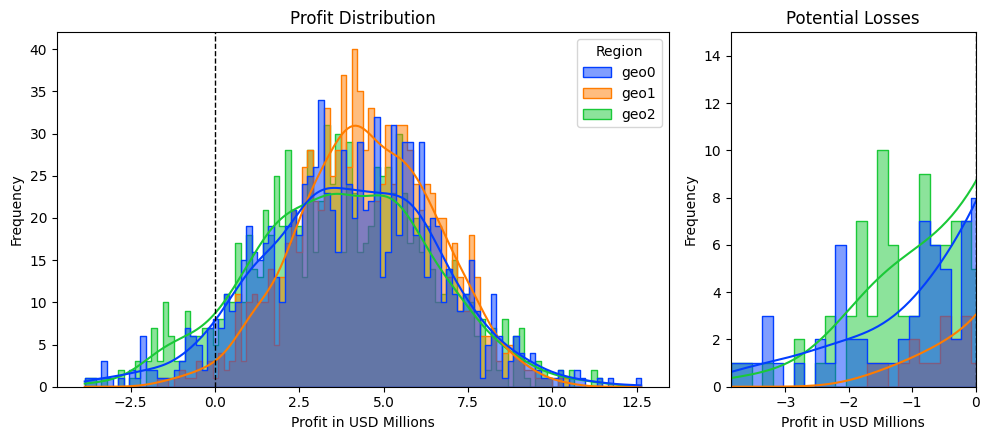

In [41]:
df_bs = pd.DataFrame([
    {'Region': region, 'profit': p / 1_000_000}
    for region, data in top_200_bs.items()
    for p in data['g_profit_real']
])

sns.set_palette('bright')

fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), gridspec_kw={'width_ratios': [2.5, 1]})

# Full distribution
sns.histplot(data=df_bs, x='profit', hue='Region', bins=100, alpha=0.5, element='step', kde=True, ax=axes[0])
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[0].set_xlabel('Profit in USD Millions')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Profit Distribution')

# Zoomed losses
sns.histplot(data=df_bs, x='profit', hue='Region', bins=100, alpha=0.5, element='step', kde=True, ax=axes[1], legend=False)
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].set_xlim(df_bs['profit'].min(), 0)
axes[1].set_ylim(0, 15)
axes[1].set_xlabel('Profit in USD Millions')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Potential Losses')

plt.tight_layout()
plt.show()

As noted above, it must be noted that `geo1` is artificially clustered around select values, likely explaining the denser central clustering and the lower frequency of profit loss in region `geo1`. 

### Risk of Loss

Finally risk of profit loss was calculated as the percent incidence of negative profit within each of the 1000 bootstraps. It was found that:

- Risk of Loss in Region geo0:  6.0 %
- Risk of Loss in Region geo1:  1.5 %
- Risk of Loss in Region geo2:  8.0 %

In [42]:
for region, df in top_200_bs.items():
    top_200_bs[region]['losses'] = sum(1 for profit in top_200_bs[region]['g_profit_real'] if profit<0)
    top_200_bs[region]['risk'] = top_200_bs[region]['losses'] / boot_straps

    print('Risk of Loss in Region',region,top_200_bs[region]['risk']*100,'%' )



Risk of Loss in Region geo0 6.0 %
Risk of Loss in Region geo1 1.5 %
Risk of Loss in Region geo2 8.0 %


# Well Selection

From bootstrap analysis, it was found that `geo1` has the least risk of profit loss at 1.5%. Accordingly, no profit loss was identified in the 95% confidence interval. **However**, while this meets our risk tolerance of 2.5%, given the clustering seen in `geo1`, there is not enough information to make a recommendation at this time. Data preparation methods will need to be interrogated. 

As linear regression was determined to be poor models for the other regions, with RSME scores roughly 30-40% of average reserves, further exploration into `geo0` and `geo2` is warrented. As noted in initial model training, our most profitable top-200 wells are located in `geo0` and `geo2`. Possible explorations include ruling out multicollinearity, determining possible interaction effects amongst featurs, or exploring polynomial regression models. 


# Conclusion

We are unable to make a confident recommendation at this time. While `geo1` was determined to be a potential contender, further exploration needs to be made before disqualifing our other regions. 